In [16]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nb_classes = 11
batch_size = 32

#Using Inception Model and Residual Connections

In [17]:
def Conv2D(
    x,
    filters,
    kernel_size,
    strides=1
):
  x = layers.Conv2D(
      filters,
      kernel_size,
      strides=strides,
      padding='same'
  )(x)
  x = layers.BatchNormalization(axis=3)(x)
  return x

In [18]:
def inception_resnet_block8(x, scale):

  # Inception Block

  branch_0 = Conv2D(x, 192, 1)
  branch_1 = Conv2D(x, 192, 1)
  branch_1 = Conv2D(branch_1, 224, [1, 3])
  branch_1 = Conv2D(branch_1, 256, [1, 3])
  branches = [branch_0, branch_1]
  channel_axis = 1 if backend.image_data_format() == "channels_first" else 3
  concatenate = layers.Concatenate(axis=channel_axis)(branches)
  concatenate = Conv2D(concatenate, backend.int_shape(x)[channel_axis], 1)

  # Residual Connection: ResNet

  x = layers.Lambda(
    lambda inputs, scale: inputs[0] + inputs[1] * scale,
    output_shape=backend.int_shape(x)[1:],
    arguments={"scale": scale},
  )([x, concatenate])
  x = layers.Activation('relu')(x)
  return x

In [28]:
def build_model(input_shape=(224, 224, 3)):
  img_input = layers.Input(input_shape)

  x = Conv2D(img_input, 32, 3, strides=2)
  x = Conv2D(x, 64, 3)
  x = Conv2D(x, 64, 3)
  x = layers.MaxPooling2D(3, strides=2)(x)
  x = Conv2D(x, 64, 1)
  x = Conv2D(x, 80, 3)
  x = layers.MaxPooling2D(3, strides=2)(x)
  x = Conv2D(x, 64, 1)
  x = Conv2D(x, 80, 3)
  x = layers.MaxPooling2D(3, strides=2)(x)
  x = Conv2D(x, 64, 1)
  x = Conv2D(x, 80, 3)
  x = layers.MaxPooling2D(3, strides=2)(x)
#   x=incept_module(x,[16,64])
#   x = layers.MaxPooling2D(3, strides=2)(x)
#   x=incept_module(x,[32,64])

#   Inception Block
#   branch_0 = Conv2D(x, 96, 1)
#   branch_1 = Conv2D(x, 48, 1)
#   branch_1 = Conv2D(branch_1, 64, 5)
#   branch_2 = Conv2D(x, 64, 1)
#   branch_2 = Conv2D(branch_2, 96, 3)
#   branch_2 = Conv2D(branch_2, 96, 3)
#   branch_pool = layers.AveragePooling2D(3, strides=1, padding="same")(x)
#   branch_pool = Conv2D(branch_pool, 64, 1)
#   branches = [branch_0, branch_1, branch_2, branch_pool]
#   x = layers.Concatenate(axis=3, name="mixed_5b")(branches)
  for _ in range(3):
    x = inception_resnet_block8(x, scale=0.1)
    x = layers.MaxPooling2D(3, 2, padding='same')(x)
    x = layers.Dropout(0.1)(x)
  model = models.Model(img_input, x, name='inception_resnet')
  return model

In [29]:
conv_base = build_model()
conv_base.summary()

Model: "inception_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_52 (Conv2D)             (None, 112, 112, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 112, 112, 32  128        ['conv2d_52[0][0]']              
 ormalization)                  )                                                  

In [30]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(45, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(11, activation='softmax'))
# conv_base.trainable = True
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

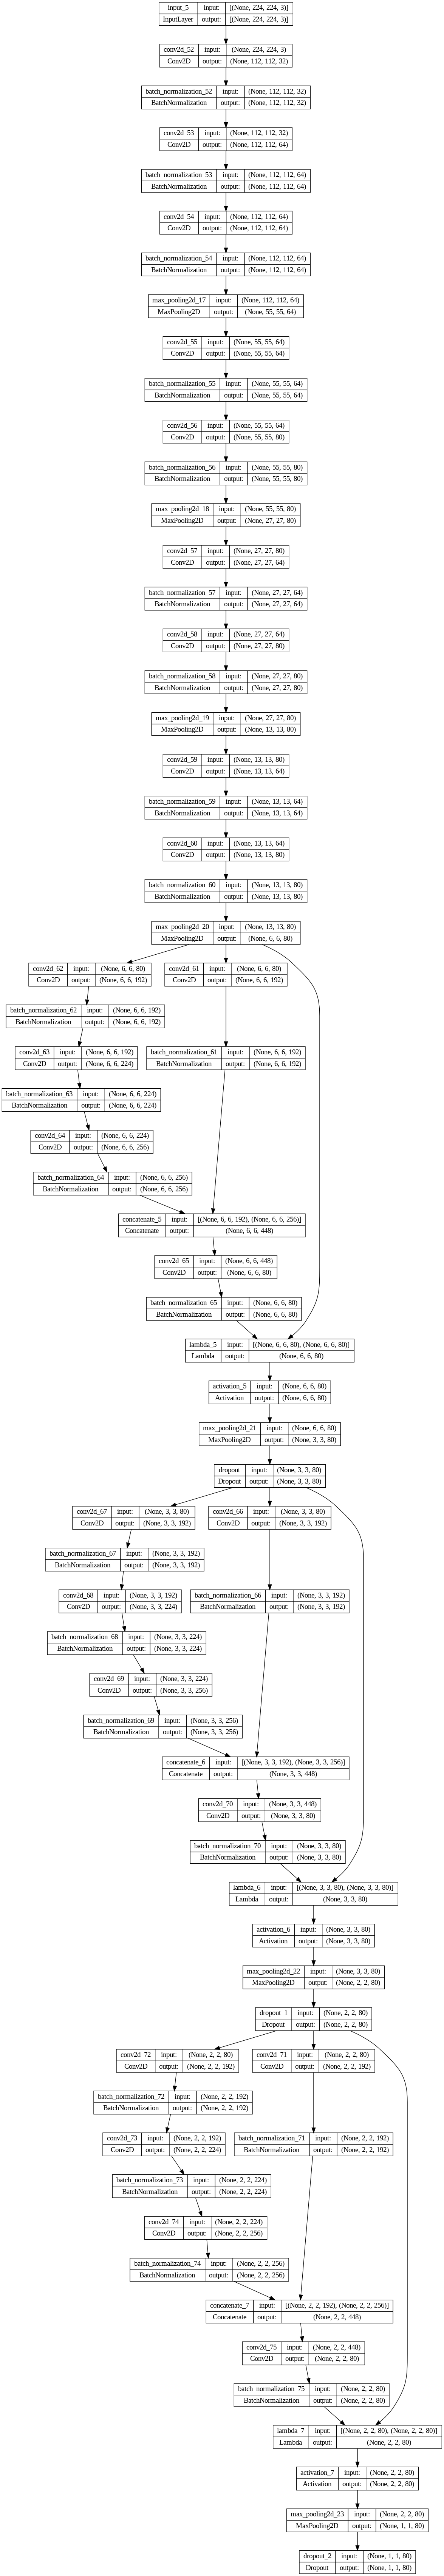

In [31]:
plot_model(conv_base, to_file='conv_base.png', show_shapes=True)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet (Functiona  (None, 1, 1, 80)         1328704   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 80)                0         
                                                                 
 dense_4 (Dense)             (None, 45)                3645      
                                                                 
 dense_5 (Dense)             (None, 11)                506       
                                                                 
Total params: 1,332,855
Trainable params: 1,326,007
Non-trainable params: 6,848
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Augumentation

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/states_dataset/train/'
VALIDATION_DIR = "/content/drive/MyDrive/states_dataset/valid/"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the height
    shear_range=0.2,  # apply shearing transformations
    zoom_range=0.2,  # zoom in on images by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 8583 images belonging to 11 classes.
Found 1912 images belonging to 11 classes.


In [ ]:
history = model.fit(
    train_generator,
#     steps_per_epoch=200,
    epochs=50,
    validation_data=validation_generator,
#     validation_steps=16
)

Epoch 1/50
269/269 [==============================] - 70s 253ms/step - loss: 2.2225 - acc: 0.2094 - val_loss: 2.3520 - val_acc: 0.2249
Epoch 2/50
269/269 [==============================] - 68s 253ms/step - loss: 1.9928 - acc: 0.2922 - val_loss: 2.2721 - val_acc: 0.2474
Epoch 3/50
269/269 [==============================] - 69s 255ms/step - loss: 1.8798 - acc: 0.3373 - val_loss: 2.0441 - val_acc: 0.3180
Epoch 4/50
269/269 [==============================] - 69s 256ms/step - loss: 1.8139 - acc: 0.3601 - val_loss: 1.8493 - val_acc: 0.3666
Epoch 5/50
269/269 [==============================] - 70s 258ms/step - loss: 1.7709 - acc: 0.3825 - val_loss: 2.1272 - val_acc: 0.3300
Epoch 6/50
269/269 [==============================] - 68s 252ms/step - loss: 1.7192 - acc: 0.3999 - val_loss: 1.8283 - val_acc: 0.3713
Epoch 7/50
269/269 [==============================] - 69s 256ms/step - loss: 1.6758 - acc: 0.4218 - val_loss: 1.9135 - val_acc: 0.3917
Epoch 8/50
269/269 [==============================] - 6

In [ ]:
history1 = model.fit(
    train_generator,
#     steps_per_epoch=200,|
    epochs=1,
    validation_data=validation_generator,
#     validation_steps=16
)

269/269 [==============================] - 77s 284ms/step - loss: 1.0798 - acc: 0.6305 - val_loss: 1.1597 - val_acc: 0.6156


In [ ]:
import matplotlib.pyplot as plt

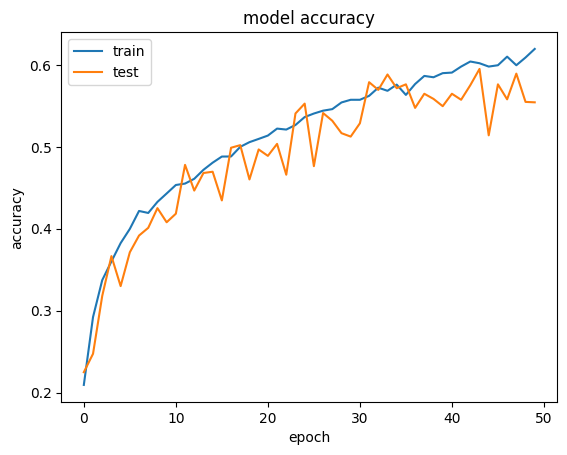

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

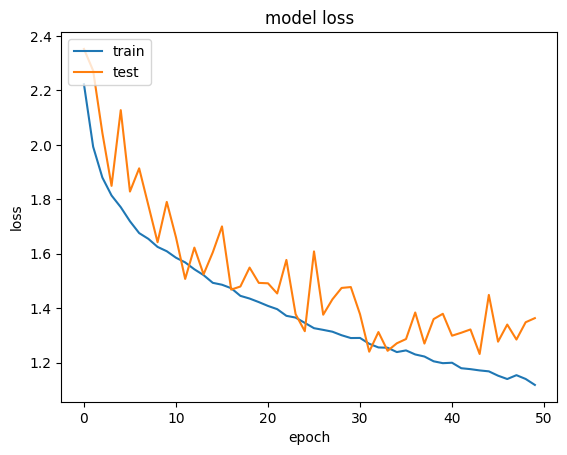

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('my_model_2.h5')

#Testing script

In [13]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend
from keras.engine import training
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.utils import to_categorical
from keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, Conv2D, AveragePooling2D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [14]:
from google.colab import drive
drive.mount('/content/drive')

TEST_DIR = "/content/drive/MyDrive/test"
TEST_TRUTH = "/content/drive/MyDrive/ground_truth.json"

Mounted at /content/drive


In [15]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

test_filenames = [filename.split("/")[1] for filename in test_generator.filenames]
# test_images = test_generator.next()

class_indices ={'creamy_paste': 0, 'diced': 1, 'floured': 2, 'grated': 3, 'juiced': 4, 'jullienne': 5, 'mixed': 6, 'other': 7, 'peeled': 8, 'sliced': 9, 'whole': 10}
# print(class_indices)
#model loading
model=tf.keras.models.load_model('/content/drive/MyDrive/my_model_2.h5')
model.summary()


test_truth_data = json.load(open(TEST_TRUTH))
test_truth = to_categorical([class_indices[test_truth_data[filename]] for filename in test_filenames])
prediction_json = model.predict(test_generator)
# print(prediction_json)
prediction_json=np.argmax(prediction_json,axis=-1)
class_names=[]
# print(prediction_json)
final_predicted_json={}
for x,y in class_indices.items():
  class_names.append(x)
pred_class_names = [class_names[label] for label in prediction_json]
for x in range(len(pred_class_names)):
  final_predicted_json[test_filenames[x]]=pred_class_names[x]

print(final_predicted_json)  

with open('/content/drive/MyDrive/prediction.json', 'w+') as f:
  json.dump(final_predicted_json,f,indent=6)

    


Found 500 images belonging to 1 classes.
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet (Functiona  (None, 1, 1, 80)         1328704   
 l)                                                              
                                                                 
 flatten_20 (Flatten)        (None, 80)                0         
                                                                 
 dense_40 (Dense)            (None, 45)                3645      
                                                                 
 dense_41 (Dense)            (None, 11)                506       
                                                                 
Total params: 1,332,855
Trainable params: 1,326,007
Non-trainable params: 6,848
_________________________________________________________________
16/16 [==============================] - 34s 2s/step
{'0001.jpg'